In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.metrics import roc_auc_score
import joblib

# Cofigure tunable params

In [2]:
mu_values = np.arange(0,50)/10
plotDir = "plots/Toy/"
nBins = 10
aug_NN = False # if training NN for data augmentation instead of LDA- feature removed

In [3]:
useAuxZMeasure = False
#useAuxZMeasure = True

if useAuxZMeasure:
    plotDir = "plots/Toy/AuxMeasure/"

In [4]:
clfCol = "b"; aweCol = "g"; augCol = "y"; invCol = "r"; clfNomCol = "k"

In [5]:
n_events = n_z = 2 * 10**6 # dataset size per z
feature_std = 0.7; r = 1. 

z_nominal = np.pi/4
z_std = 0.5

n_shifts = 21
syst_shifts = np.arange(0,21)/10 # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]
assert len(syst_shifts)==n_shifts
z_syst =  z_nominal * syst_shifts
systUp = z_nominal * syst_shifts[-1]

# TF GPU settings

In [6]:
onlyCPU = False
#onlyCPU = True


import os
import tensorflow as tf

if onlyCPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

# Generate Dataset

In [ ]:
X_sig_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T 
              for i in range (n_shifts)])
Y_sig_syst = np.array([np.ones(n_events) for i in range (n_shifts)])
centres_sig_syst = np.array([r* np.vstack([np.cos(z_syst[i]), np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_sig_syst += centres_sig_syst

X_back_syst = np.array([np.vstack( [np.random.normal(0, feature_std, n_events), np.random.normal(0, feature_std, n_events)]).T
                        for i in range (n_shifts)])
Y_back_syst = np.array([np.zeros(n_events) for i in range (n_shifts)])
centres_back_syst = np.array([r* np.vstack([-np.cos(z_syst[i]), -np.sin(z_syst[i])]).T for i in range(n_shifts)])
X_back_syst += centres_back_syst

X_syst = np.concatenate([X_sig_syst,X_back_syst], 1)
Y_syst = np.hstack([Y_sig_syst,Y_back_syst])
Z_syst  = np.ones_like(Y_syst) * z_syst.reshape(-1,1)

In [ ]:
plt.hist2d(X_syst[0,:,0], X_syst[0,:,1], bins=20)
plt.title("Syst angle {} Dataset (signal and background)".format(np.round(z_syst[0],2)))
#plt.savefig(plotDir + "systDown_dataset.pdf")
plt.show()

In [ ]:
plt.hist2d(X_syst[-1,:,0], X_syst[-1,:,1], bins=20)
plt.title("Syst angle {} Dataset (signal and background)".format(np.round(z_syst[-1],2)))
#plt.savefig(plotDir + "systUp_dataset.pdf")
plt.show()

In [ ]:
X_syst = X_syst.reshape(-1,X_syst.shape[-1])
Y_syst = Y_syst.reshape(-1)
Z_syst = Z_syst.reshape(-1)

## Shuffle and split train test

In [ ]:
from sklearn.model_selection import train_test_split
X_syst_train, X_syst_test, Y_syst_train, Y_syst_test, Z_syst_train, Z_syst_test  = train_test_split(X_syst,Y_syst,Z_syst, shuffle=True)

## Save Load datasets

## Calc indices

In [8]:
systUpEvents = np.isclose(Z_syst_test, systUp)
nominalEvents = np.isclose(Z_syst_test, z_nominal)

## Contour plot of data

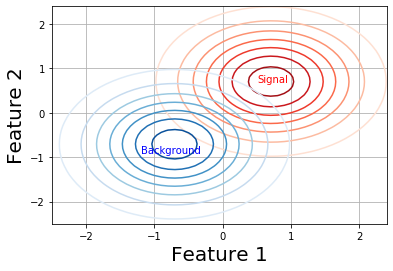

In [9]:
from scipy.stats import multivariate_normal

# Contour plots
lims = 2.5
x, y = np.mgrid[-lims:lims:.1, -lims:lims:.1]
pos = np.dstack((x, y))
signal_pdf = multivariate_normal([np.cos(np.pi/4), np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
back_pdf = multivariate_normal([-np.cos(np.pi/4), -np.sin(np.pi/4)], [[0.7, 0], [0, 0.7]])
plt.contour(x, y, signal_pdf.pdf(pos), cmap="Reds")
plt.text(0.5,0.7, "Signal", color="Red")
plt.contour(x, y, back_pdf.pdf(pos), cmap="Blues")
plt.text(-1.2,-0.9, "Background", color="Blue")
plt.grid(b=True, which="major")

plt.xlabel("Feature 1", fontsize="20")
plt.ylabel("Feature 2", fontsize="20")


#plt.savefig(plotDir + "Toy_Nominal_Dataset_Countour.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

# Train/Define Models

## Clf on Nominal

In [10]:
class nominalModel:
    def predict(self,X):
        from scipy.stats import multivariate_normal
        angle = np.pi/4
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
nominal_model = nominalModel()

In [11]:
Y_predict_nomOnSys = nominal_model.predict(X_syst_test[systUpEvents]).reshape(-1)
Y_predict_nomOnnom = nominal_model.predict(X_syst_test[nominalEvents]).reshape(-1)

In [12]:
print ("Test AUC nom on nom: ", roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_nomOnnom))
print ("Test AUC nom on syst: ", roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_nomOnSys ))

Test AUC nom on nom:  0.9780795659875026
Test AUC nom on syst:  0.9235543790273305


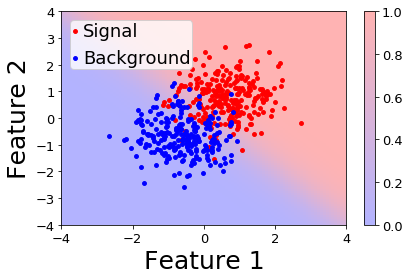

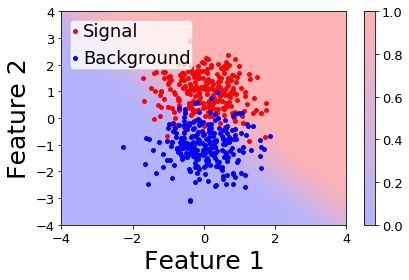

In [13]:
def decisionFuncPlot(model, clfName, z_val=z_nominal):
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=25)     # fontsize of the axes title
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
    plt.rc('legend', fontsize=18)    # legend fontsize
    plt.rcParams.update({'figure.autolayout': True})


    zval_Events = np.isclose(Z_syst_test, z_val)
    # Colormap
    cmap = colors.LinearSegmentedColormap(
        'red_blue_classes',
        {'red': [(0, 1, 1), (1, 0.7, 0.7)],
         'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
         'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
    plt.cm.register_cmap(cmap=cmap)
    color_map = plt.cm.get_cmap('red_blue_classes')
    cmap_reversed = cmap.reversed() # red for 1 blue for 0 instead

    # class 0 and 1 : areas
    nx, ny = 100, 100
    x_min, x_max = -4,4
    y_min, y_max = -4,4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
    if clfName == "Aware":
        Z = model.predict([np.c_[xx.ravel(), yy.ravel()],(z_val)*np.ones(len(xx.ravel()))])
    elif (clfName == "Nominal") or (clfName == "Invariant") or (clfName == "Up"):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    elif clfName == "Augmented":
        if aug_NN:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
    Z = Z.reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, Z, cmap=cmap_reversed,
               norm=colors.Normalize(0., 1.), zorder=0)
    cbar = plt.colorbar()
    ppc = 250 # scatter points per class
    s = 15.
    plt.scatter(X_syst_test[zval_Events & (Y_syst_test==1)][:ppc,0], X_syst_test[zval_Events & (Y_syst_test==1)][:ppc,1],
                color="red", s=s,label="Signal")
    plt.scatter(X_syst_test[zval_Events & (Y_syst_test==0)][:ppc,0], X_syst_test[zval_Events & (Y_syst_test==0)][:ppc,1],
                color="blue", s=s, label="Background")

    #plt.title("Decision Function of {} Classifier on Z={}".format(clfName, np.round(z_val,2)))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(borderpad=0.1, handlelength=0.3, handletextpad=0.3)
    plt.tight_layout()
#     plt.savefig(plotDir+"DecisionFunction_{}_on_Z{}.pdf".format(clfName, np.round(z_val,2)),
#                 bbox_inches='tight',pad_inches = 0)
    plt.show()



decisionFuncPlot(model=nominal_model, clfName="Nominal", z_val=z_nominal)
decisionFuncPlot(model=nominal_model, clfName="Nominal", z_val=systUp)

## Train Data Augmented Model

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
augmented_model = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

In [15]:
#train model
augmented_model.fit(X_syst_train, Y_syst_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=True, tol=0.0001)

In [16]:
Y_predict_augOnSys = augmented_model.predict_proba(X_syst_test[np.isclose(Z_syst_test, systUp)])[:,1].reshape(-1)

In [17]:
print ("Test AUC Aug on Syst: ",roc_auc_score(y_true=Y_syst_test[np.isclose(Z_syst_test, systUp)], y_score=Y_predict_augOnSys ))

Test AUC Aug on Syst:  0.9235317349893359


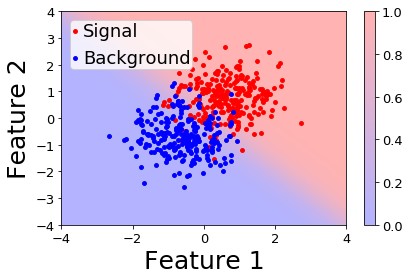

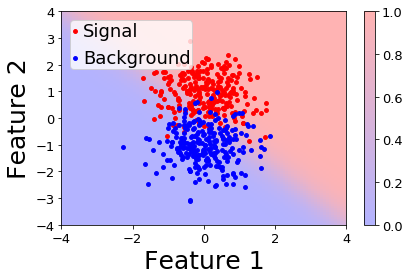

In [18]:
decisionFuncPlot(model=augmented_model, clfName="Augmented", z_val=z_nominal)
decisionFuncPlot(model=augmented_model, clfName="Augmented", z_val=systUp)

## Syst Aware Model

In [19]:
class awareModel:
    def predict(self,inputs):
        X, angle = inputs[0], inputs[1]
        from scipy.stats import multivariate_normal
        angle = np.array(angle)
        assert (angle == angle[0]).all()
        angle = angle[0]
        rv_signal = multivariate_normal((np.cos(angle),np.sin(angle)),(feature_std,feature_std)).pdf
        rv_back = multivariate_normal((-np.cos(angle),-np.sin(angle)),(feature_std,feature_std)).pdf
        score = rv_signal(X)/(rv_signal(X) + rv_back(X))
        return score
aware_model = awareModel()

In [20]:
Y_predict_AweOnSys = aware_model.predict([X_syst_test[systUpEvents], Z_syst_test[systUpEvents]]).reshape(-1)
Y_predict_AweIfNom = aware_model.predict([X_syst_test[systUpEvents], z_nominal* np.ones_like(Z_syst_test[systUpEvents])]).reshape(-1)
Y_predict_AweOnNom = aware_model.predict([X_syst_test[nominalEvents], z_nominal* np.ones(nominalEvents.sum())]).reshape(-1)
Y_predict_AweIfSys = aware_model.predict([X_syst_test[nominalEvents], systUp* np.ones(nominalEvents.sum())]).reshape(-1)

In [21]:
print ("Test AUC Awe on Nom: ",roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_AweOnNom ))
print ("Test AUC Awe on Syst: ",roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_AweOnSys ))

Test AUC Awe on Nom:  0.9780795659875026
Test AUC Awe on Syst:  0.9782763788819256


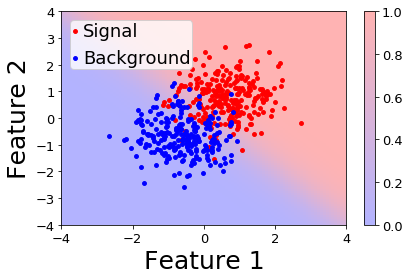

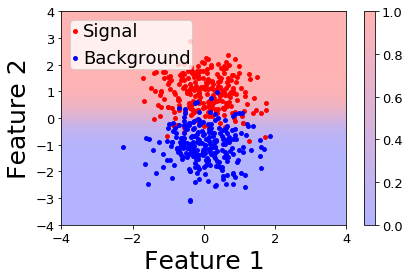

In [22]:
decisionFuncPlot(model=aware_model, clfName="Aware", z_val=z_nominal)
decisionFuncPlot(model=aware_model, clfName="Aware", z_val=systUp)

## Train Pivot

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from gradRevLayer import GradReverseTR as GradReverse

n_hidden_inv = 10; n_hidden_inv_R = 10
n_nodes_inv = 64; n_nodes_inv_R = 64
hp_lambda = 1.

inputs = Input(shape=(X_syst_train.shape[1],))

Dx = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv_R -1):
    Dx = Dense(n_nodes_inv_R, activation='relu', kernel_regularizer='l2')(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
inv_model = Model(inputs=inputs, outputs=Dx)

GRx = GradReverse()(Dx)
Rx = Dense(n_nodes_inv, activation="relu")(GRx)
for i in range(n_hidden_inv -1):
    Rx = Dense(n_nodes_inv, activation='relu', kernel_regularizer='l2')(Rx)
#Rx = Dense(1, activation="sigmoid")(Rx)
Rx = Dense(1, activation="linear")(Rx)
GR = Model(inputs=inputs, outputs=[Dx, Rx])

GR.compile(loss=["binary_crossentropy", "mean_squared_error"], optimizer="RMSProp")

In [ ]:
n_epochs = 1 # 100
GR.fit(x=X_syst_train, y=[Y_syst_train, Z_syst_train], epochs=n_epochs, batch_size=4*1024)

In [24]:
Y_predict_InvOnSys = inv_model.predict(X_syst_test[systUpEvents], batch_size=4*1024).reshape(-1)
Y_predict_InvOnNom = inv_model.predict(X_syst_test[nominalEvents], batch_size=4*1024).reshape(-1)

In [25]:
#print ("Train AUC Awe on Aug: ", roc_auc_score(y_true=Y_test, y_score=Y_predict_AweOnAug))
print ("Test AUC Inv on Nom: ",roc_auc_score(y_true=Y_syst_test[nominalEvents], y_score=Y_predict_InvOnNom ))
print ("Test AUC Inv on Syst: ",roc_auc_score(y_true=Y_syst_test[systUpEvents], y_score=Y_predict_InvOnSys ))

Test AUC Inv on Nom:  0.9780772692468657
Test AUC Inv on Syst:  0.9237466548352726


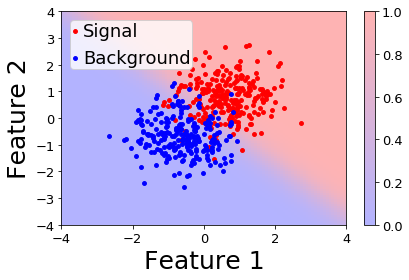

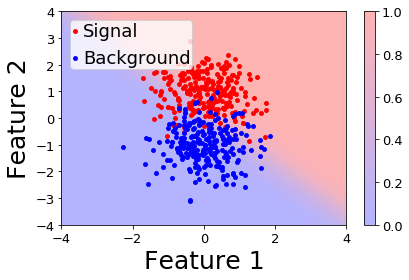

In [26]:
decisionFuncPlot(model=inv_model, clfName="Invariant", z_val=z_nominal)
decisionFuncPlot(model=inv_model, clfName="Invariant", z_val=systUp)

#  Likelihoods

In [27]:
def nll_stat(N,S,B,mu):
    from scipy.special import loggamma
    nexp=mu*S+B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    if np.isinf(nll_stat):
        print (N, nexp)
    return nll_stat

def nll_syst(dTheta, sigma=1):
    nll_syst = - (np.log (1/(sigma*np.sqrt(2*np.pi))) + (-0.5 * (dTheta/sigma)**2))
    return nll_syst

def nll_aux(N,B):
    from scipy.special import loggamma
    nexp=B
    nll_stat = - (N* np.log(nexp) - nexp - loggamma(N) ) # Poisson
    return nll_stat

In [28]:
true_mu = 1; # variable never used
sigScaling = 1/(10**3.) # because signal is usually much smaller than background but we produced equal
backScaling = sigScaling*100 
weights_syst = np.ones_like(Y_syst_test)
weights_syst[Y_syst_test==1] *=sigScaling
weights_syst[Y_syst_test==0] *=backScaling


# Build Aux data

In [29]:
if useAuxZMeasure:
    aux_std = 0.5; n_aux = 10**5; aux_hist_range=(-1,2.5)
    weight_aux = 1/10. * np.ones(n_aux)
    aux_hists = []
    nBinsAux = 4
    for z_val in z_syst:
        hist_aux, bin_array_aux = np.histogram(
            np.random.normal(z_val, aux_std, n_aux), 
            weights=weight_aux, range=aux_hist_range, bins=nBinsAux)
        aux_hists.append(hist_aux)
    aux_hists = np.array(aux_hists) 
    # always exacty same number of events unlike with train-test split

In [30]:
if useAuxZMeasure:
    nominal_aux_events = np.where(z_syst==z_nominal)[0][0]
    systUp_aux_events = np.where(z_syst==systUp)[0][0]

# Building templates, 2D NLL

In [32]:
def buildTemplates(model, clfName,nBins=nBins):
    sig_hists = []
    back_hists = []
    for z_val in z_syst:
        zEvents = np.isclose(Z_syst_test, z_val)
        if (clfName == "Aware"):
            print ("Not Currently Supported for analyticial aware classifier")
            Y_pred_model = model.predict([X_syst_test,Z_syst_test]).reshape(-1)
        elif (clfName == "Invariant"):
            Y_pred_model = model.predict(X_syst_test, batch_size=4000).reshape(-1)
        elif ((clfName == "Nominal") or (clfName == "Augmented") or (clfName == "Up")):
            if (clfName == "Augmented") and (~aug_NN):
                Y_pred_model = model.predict_proba(X_syst_test)[:,1].reshape(-1)
            else:
                Y_pred_model = model.predict(X_syst_test).reshape(-1)
        else:
            print ("Unexpected Clf name!!")
            
        hist_sig, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==1)], 
            weights=weights_syst[zEvents &(Y_syst_test==1)], range=(0,1), bins=nBins)
        hist_back, bin_array = np.histogram(
            Y_pred_model[zEvents &(Y_syst_test==0)], 
            weights=weights_syst[zEvents &(Y_syst_test==0)], range=(0,1), bins=nBins)
            
        sig_hists.append(hist_sig)
        back_hists.append(hist_back)
    sig_hists = np.array(sig_hists)
    back_hists = np.array(back_hists)
    return sig_hists, back_hists

In [33]:
def computeNLL2D(obs1D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std)
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D


In [34]:
def computeNLL2D_aux(obs1D, obsAux1D, sH2d, bH2d, expAux2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert len(obs1D) == sH2d.shape[1] == bH2d.shape[1]
    assert len(obsAux1D) == expAux2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])    
    for i, z_val in enumerate(z_syst):
        for nn,bb in zip(obsAux1D,expAux2d[i]):
            bin_nll_aux = nll_aux(N=nn,B=bb)
            if (not np.isnan(bin_nll_aux)):
                nll2D[:,i] += bin_nll_aux

        for k,mu in enumerate(mu_values):
            for n,s,b in zip(obs1D, sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [35]:
def plotNLLCurves(x, y_list, label_list, color_list, linestyle_list, testDataLabel, 
                  xlim=[0.3, 1.8], ylim=[0,10],
                  ylimRatio=[0.8, 1.2], legendOrder=None, showLegend=True):
    # assumes last y is reference
    ref_y = y_list[-1]
    
    if showLegend:
        fig = plt.figure(figsize=(5, 15/4)) 
    else:
        fig = plt.figure(figsize=(5, 3)) 
    ax0 = plt.subplot()
    
   
    for (y, lab, col, ls) in zip(y_list, label_list, color_list, linestyle_list):
        ax0.plot(x,y, label=lab, color=col, linestyle=ls)
    ax0.set_ylim(ylim)
    ax0.set_xlim(xlim)
    if showLegend:
        if (legendOrder is None):
            plt.legend(prop={'size': 10}, loc="lower right")
        else:
            handles, labels = ax0.get_legend_handles_labels()
            # re-order and legend in one step
            ax0.legend([handles[i] for i in legendOrder], [labels[i] for i in legendOrder], 
                       prop={'size': 14.38}, loc=(-0.15,1.04), handletextpad=0.1, borderpad=0.12,
                      handlelength=1, ncol=2 ) 
    plt.xlabel(r'$\mu$', fontsize=15)
    plt.ylabel(r'NLL - min(NLL)', fontsize=15)
    plt.tight_layout()

# Evaluate Models

## Baseline Classifier (trained on Nominal only)

In [ ]:
sig_hists, back_hists = buildTemplates(model=nominal_model, clfName="Nominal")

In [37]:
def createHistObs(X, weights, model,):
    Y = model.predict(X,).reshape(-1)
    hist_obs, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
    return hist_obs, bin_array

In [ ]:
hist_obs, bin_array = createHistObs(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents], 
              model=nominal_model)

In [39]:
if useAuxZMeasure:
    nll2D_clf_nom = computeNLL2D_aux(obs1D=hist_obs,  sH2d=sig_hists, bH2d=back_hists,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_clf_nom = computeNLL2D(obs1D=hist_obs, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 0.7853981633974483


In [40]:
def plot2dNLL(nll2D, dataName, clfName):
    xx, yy = np.meshgrid(mu_values,z_syst)
    ind = np.unravel_index(np.argmin(nll2D, axis=None), nll2D.shape)
    plt.pcolormesh(xx,yy,(nll2D-nll2D.min() + 1).T,)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r"NLL", labelpad=0)
    cbar.ax.set_ylabel(r"NLL - min(NLL) + 1", labelpad=5, size=15)
    cbar.formatter.set_powerlimits((0, 0))
    plt.scatter(mu_values[ind[0]],z_syst[ind[1]] , color="crimson", s=200)
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$z$")

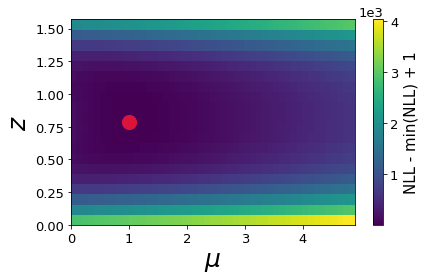

In [41]:
plot2dNLL(nll2D=nll2D_clf_nom, dataName="Nominal", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [42]:
nll1D_clf_nom = nll2D_clf_nom.min(axis=1)

In [ ]:
hist_obs_systUp, bin_array = createHistObs(X=X_syst_test[systUpEvents], weights=weights_syst[systUpEvents], 
              model=nominal_model)

In [45]:
nll2D_clf_systUp = computeNLL2D(obs1D=hist_obs_systUp, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.5707963267948966


In [46]:
if useAuxZMeasure:
    nll2D_clf_systUp = computeNLL2D_aux(obs1D=hist_obs_systUp,  sH2d=sig_hists, bH2d=back_hists,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_clf_systUp = computeNLL2D(obs1D=hist_obs_systUp, sH2d=sig_hists, bH2d=back_hists)

Min at mu,z:  1.0 1.5707963267948966


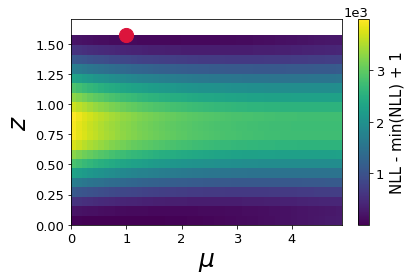

In [47]:
plot2dNLL(nll2D=nll2D_clf_systUp, dataName="SystUp", clfName="Clf")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Clf", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [48]:
nll1D_clf_systUp = nll2D_clf_systUp.min(axis=1)

### Show templates

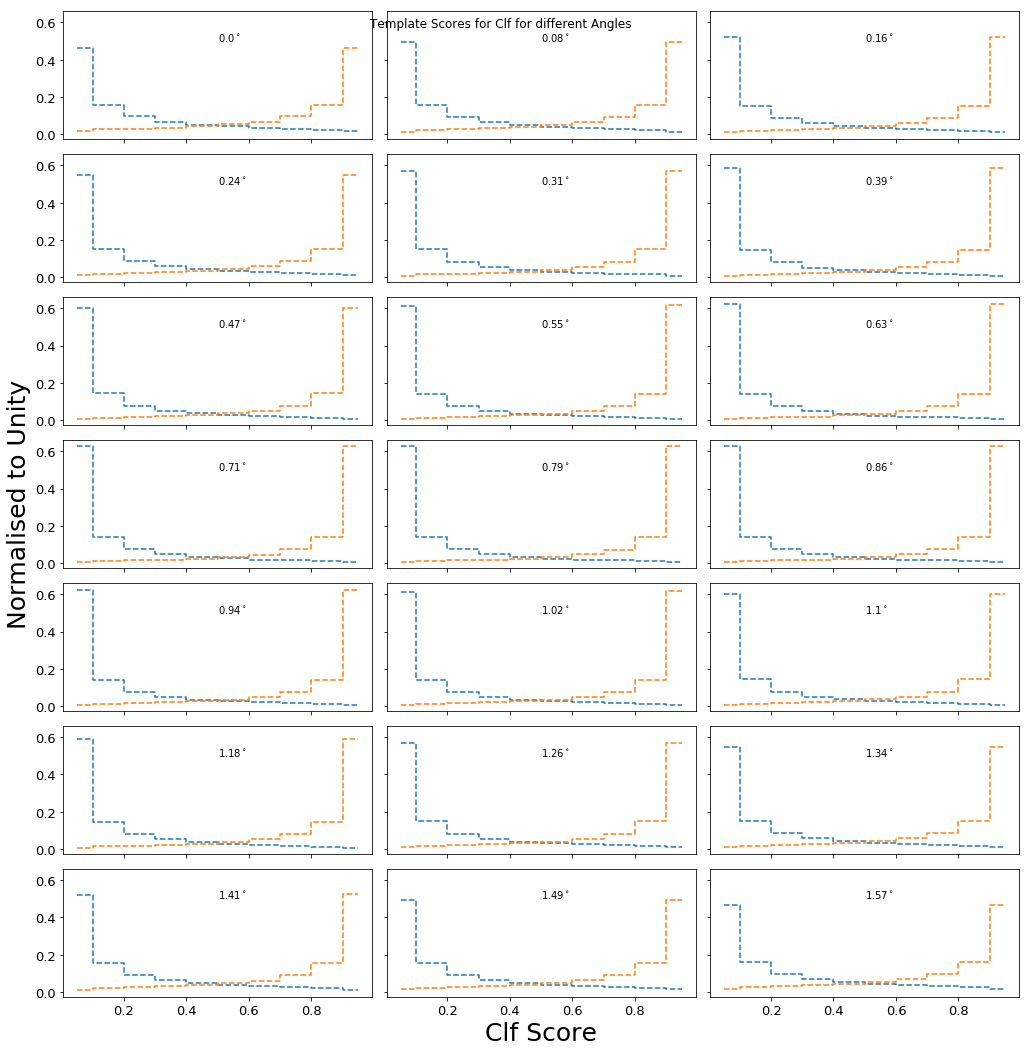

In [49]:
def show_templates(sHists,bHists,clfName):
    bincentres = [(bin_array[i]+bin_array[i+1])/2. for i in range(len(bin_array)-1)]
    fig, axs = plt.subplots(7, 3,sharex=True, sharey=True, figsize=(15,15))
    fig.add_subplot(111, frameon=False)
    for i in range(sHists.shape[0]):
        axs[i//3,i%3].step(bincentres,bHists[i,:]/bHists[i,:].sum(),where='mid',linestyle='--', label="Signal")
        axs[i//3,i%3].step(bincentres,sHists[i,:]/sHists[i,:].sum(),where='mid',linestyle='--', label="Background")
        axs[i//3,i%3].text(0.5,0.5,r"{}$^\circ$".format(np.round(z_syst,2)[i]))
        #axs[i%7,i%3].legend()
        #axs[i%7,i%3].set_title("Template Scores for Clf using Dataset with Angle {}".format(np.round(z_syst,2)[i]))
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Normalised to Unity")
    plt.xlabel("{} Score".format(clfName))
    plt.suptitle("Template Scores for {} for different Angles".format(clfName))

show_templates(sHists=sig_hists,bHists=back_hists,clfName="Clf")
#plt.savefig(plotDir+"TemplateHist_Clf_syst.pdf")
plt.show()
    
    

## Data Augmentation trained classifier

In [ ]:
sig_hists_aug, back_hists_aug = buildTemplates(model=augmented_model, clfName="Augmented")

In [ ]:
hist_obs_aug, bin_array = np.histogram(
    augmented_model.predict_proba(X_syst_test[nominalEvents])[:,1].reshape(-1), 
    weights=weights_syst[nominalEvents], range=(0,1), bins=nBins)


In [51]:
if useAuxZMeasure:
    nll2D_aug_nom = computeNLL2D_aux(obs1D=hist_obs_aug, sH2d=sig_hists_aug, bH2d=back_hists_aug,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_aug_nom = computeNLL2D(obs1D=hist_obs_aug, sH2d=sig_hists_aug, bH2d=back_hists_aug)

nll1D_aug_nom = nll2D_aug_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


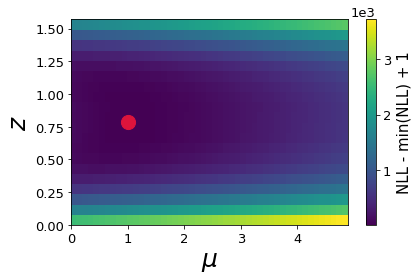

In [52]:
plot2dNLL(nll2D=nll2D_aug_nom, dataName="Nominal", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [53]:
hist_obs_aug_systUp, bin_array = np.histogram(
        augmented_model.predict_proba(X_syst_test[systUpEvents])[:,1].reshape(-1), 
        weights=weights_syst[systUpEvents], range=(0,1), bins=nBins)

In [55]:
if useAuxZMeasure:
    nll2D_aug_systUp = computeNLL2D_aux(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_aug_systUp = computeNLL2D(obs1D=hist_obs_aug_systUp, sH2d=sig_hists_aug, bH2d=back_hists_aug)

nll1D_aug_systUp = nll2D_aug_systUp.min(axis=1)

Min at mu,z:  1.0 1.5707963267948966


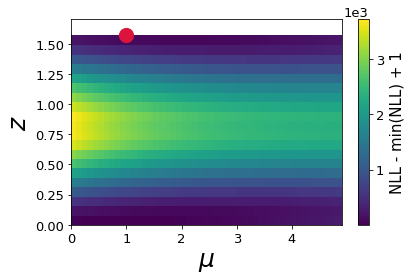

In [56]:
plot2dNLL(nll2D=nll2D_aug_systUp, dataName="SystUp", clfName="Aug")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Aug", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

## Syst Aware classifier

In [57]:
# Build templates

nBins = 10
sig_hists_awe = []
back_hists_awe = []
for z_val in z_syst:
    systEvents = np.isclose(Z_syst_test, z_val)
    hist_sign_awe, bin_array = np.histogram(
        aware_model.predict([X_syst_test[systEvents],Z_syst_test[systEvents]]).reshape(-1)[Y_syst_test[systEvents]==1], 
        weights=weights_syst[systEvents][Y_syst_test[systEvents]==1], range=(0,1), bins=nBins)
    hist_back_awe, bin_array = np.histogram(
        #FixMe no need to do the prediction twice
        aware_model.predict([X_syst_test[systEvents],Z_syst_test[systEvents]]).reshape(-1)[Y_syst_test[systEvents]==0], 
        weights=weights_syst[systEvents][Y_syst_test[systEvents]==0], range=(0,1), bins=nBins)
    sig_hists_awe.append(hist_sign_awe)
    back_hists_awe.append(hist_back_awe)
sig_hists_awe = np.array(sig_hists_awe)
back_hists_awe = np.array(back_hists_awe)
    

In [58]:
def createHistObsAwe(X, weights):
    hist_obs_awe2D = []
    for hyp_z in z_syst:
        Y = aware_model.predict([X, np.ones(X.shape[0]) * hyp_z],).reshape(-1)
        hist_obs_awe, bin_array = np.histogram(Y, weights=weights, range=(0,1), bins=nBins)
        hist_obs_awe2D.append(hist_obs_awe)
    hist_obs_awe2D = np.array(hist_obs_awe2D)
    return hist_obs_awe2D

In [ ]:
hist_obs_awe2D = createHistObsAwe(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents])

In [60]:
def computeNLL2D_aware(obs2D, sH2d, bH2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst):
        for k,mu in enumerate(mu_values):
            nll2D[k][i] += nll_syst(dTheta=z_val-z_nominal, sigma=z_std) # @ToDo: can be moved outside loop
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

def computeNLL2D_aware_aux(obs2D, obsAux1D, sH2d, bH2d, expAux2d, mu_values=mu_values):
    min_mu, min_z, minnll = 999,999,999
    assert obs2D.shape[1] == sH2d.shape[1] == bH2d.shape[1]
    assert len(obsAux1D) == expAux2d.shape[1]
    nll2D = np.zeros(mu_values.shape[0] * sH2d.shape[0]).reshape(mu_values.shape[0],sH2d.shape[0])
    for i, z_val in enumerate(z_syst):
        for nn,bb in zip(obsAux1D,expAux2d[i]):
            bin_nll_aux = nll_aux(N=nn,B=bb)
            if (not np.isnan(bin_nll_aux)):
                nll2D[:,i] += bin_nll_aux
        for k,mu in enumerate(mu_values):
            for n,s,b in zip(obs2D[i], sH2d[i], bH2d[i]): # over the bins of score histo - different from computeNLL2D()
                bin_nll = nll_stat(N=n,S=s,B=b,mu=mu)
                if (not np.isnan(bin_nll)):
                    nll2D[k][i] += bin_nll
            if nll2D[k][i] < minnll:
                minnll = nll2D[k][i]
                min_mu = mu
                min_z = z_val
    print ("Min at mu,z: ",min_mu, min_z)
    return nll2D

In [61]:
if useAuxZMeasure:
    nll2D_awe_nom = computeNLL2D_aware_aux(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_awe_nom = computeNLL2D_aware(obs2D=hist_obs_awe2D, sH2d=sig_hists_awe, bH2d=back_hists_awe)
    
nll1D_awe_nom = nll2D_awe_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


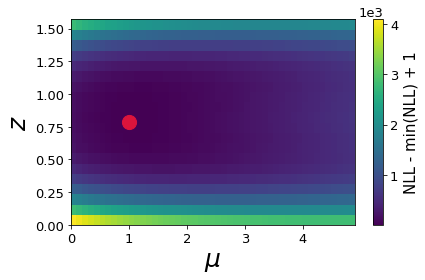

In [62]:
plot2dNLL(nll2D=nll2D_awe_nom, dataName="Nominal", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
hist_obs_awe2D_systUp = createHistObsAwe(X=X_syst_test[systUpEvents], 
                            weights=weights_syst[systUpEvents])

In [64]:
if useAuxZMeasure:
    nll2D_awe_systUp = computeNLL2D_aware_aux(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_awe_systUp = computeNLL2D_aware(obs2D=hist_obs_awe2D_systUp, sH2d=sig_hists_awe, bH2d=back_hists_awe)

Min at mu,z:  1.0 1.5707963267948966


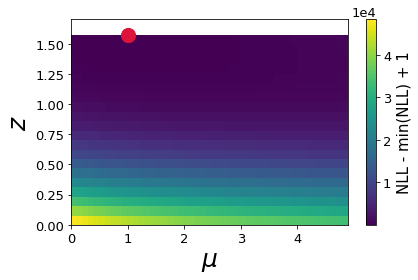

In [65]:
plot2dNLL(nll2D=nll2D_awe_systUp, dataName="SystUp", clfName="Awe")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Awe", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

In [66]:
nll1D_awe_systUp = nll2D_awe_systUp.min(axis=1)

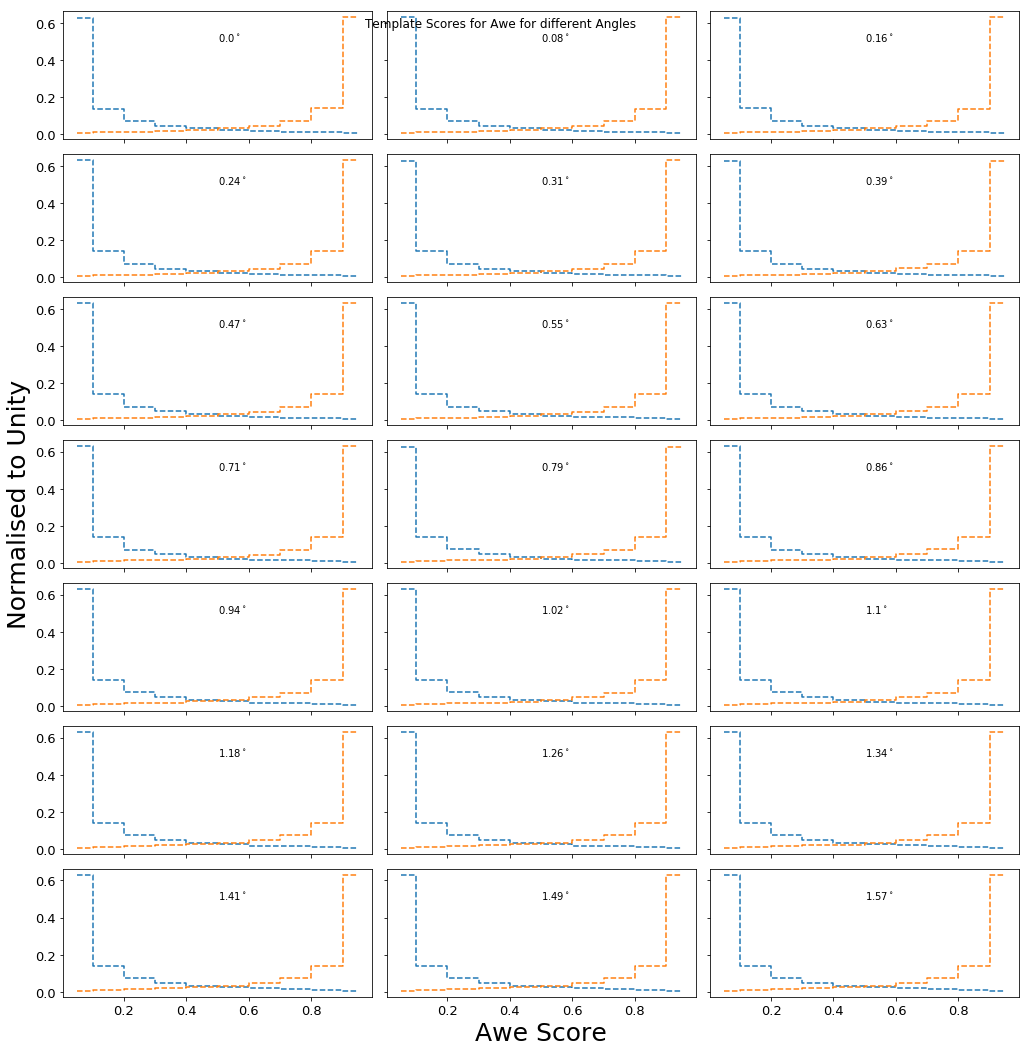

In [67]:
show_templates(sHists=sig_hists_awe,bHists=back_hists_awe,clfName="Awe")
#plt.savefig(plotDir + "TemplateHist_Awe_syst.pdf")
plt.show()

## Adversarially trained model

In [ ]:
sig_hists_inv, back_hists_inv = buildTemplates(model=inv_model, clfName="Invariant")

In [ ]:
hist_obs_inv, bin_array = createHistObs(X=X_syst_test[nominalEvents], weights=weights_syst[nominalEvents], 
              model=inv_model)

In [69]:
if useAuxZMeasure:
    nll2D_inv_nom = computeNLL2D_aux(obs1D=hist_obs_inv, sH2d=sig_hists_inv, bH2d=back_hists_inv,
                                    obsAux1D=aux_hists[nominal_aux_events], expAux2d=aux_hists)
else:    
    nll2D_inv_nom = computeNLL2D(obs1D=hist_obs_inv, sH2d=sig_hists_inv, bH2d=back_hists_inv)

nll1D_inv_nom = nll2D_inv_nom.min(axis=1)

Min at mu,z:  1.0 0.7853981633974483


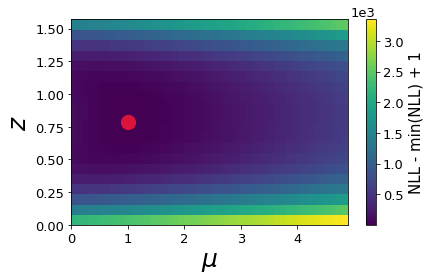

In [70]:
plot2dNLL(nll2D=nll2D_inv_nom, dataName="Nominal", clfName="Inv")
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "Nominal",), bbox_inches='tight',pad_inches = 0)
plt.show()

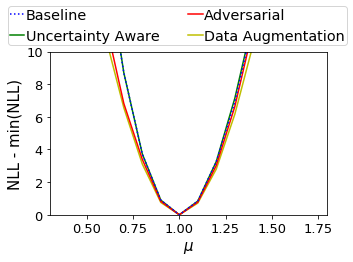

In [71]:
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_aug_nom-nll1D_aug_nom.min(), nll1D_awe_nom-nll1D_awe_nom.min(), 
                      nll1D_inv_nom-nll1D_inv_nom.min(), nll1D_clf_nom-nll1D_clf_nom.min()],
                label_list=["Data Augmentation", "Uncertainty Aware", "Adversarial","Baseline", ], 
                color_list=[augCol, aweCol, invCol,clfCol,], 
                linestyle_list=["solid", "solid", "solid", "dotted", ], 
              testDataLabel = "Nominal", ylimRatio=[0.75, 1.25], 
              legendOrder=[3,1,2,0], showLegend=True)
#plt.savefig(plotDir + "NLL_all_on_nominal.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()

In [ ]:
hist_obs_inv_systUp, bin_array = createHistObs(X=X_syst_test[systUpEvents], weights=weights_syst[systUpEvents], 
              model=inv_model)

In [73]:
if useAuxZMeasure:
    nll2D_inv_systUp = computeNLL2D_aux(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv,
                                    obsAux1D=aux_hists[systUp_aux_events], expAux2d=aux_hists)
else:    
    nll2D_inv_systUp = computeNLL2D(obs1D=hist_obs_inv_systUp, sH2d=sig_hists_inv, bH2d=back_hists_inv)

nll1D_inv_systUp = nll2D_inv_systUp.min(axis=1)

Min at mu,z:  1.0 1.5707963267948966


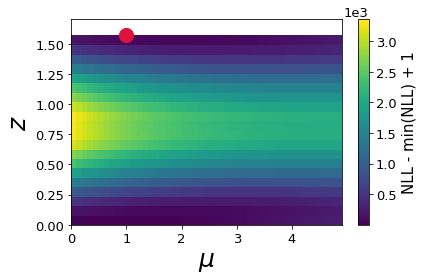

In [74]:
plot2dNLL(nll2D=nll2D_inv_systUp, dataName="SystUp", clfName="Inv") 
#plt.savefig(plotDir + "TwoD_NLL_{}_{}.pdf".format("Inv", "SystUp",), bbox_inches='tight',pad_inches = 0)
plt.show()

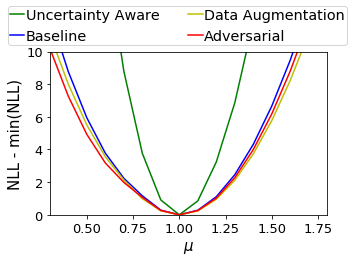

In [75]:
if useAuxZMeasure:
    lorder = [2,0,3,1] # number 2 corresponds to aware, number 0 corr to baseline, 1 to aug number 3 to inv
else:
    lorder = [2,0,1,3]
    
plotNLLCurves(x=mu_values, 
              y_list=[nll1D_clf_systUp-nll1D_clf_systUp.min(), nll1D_aug_systUp-nll1D_aug_systUp.min(),
                      nll1D_awe_systUp-nll1D_awe_systUp.min(), nll1D_inv_systUp-nll1D_inv_systUp.min(),
                      ],
                label_list=[ "Baseline", "Data Augmentation", "Uncertainty Aware", "Adversarial" ], 
                color_list=[clfCol, augCol, aweCol,  invCol], 
                linestyle_list=["solid", "solid", "solid", "solid"], 
              testDataLabel = "systUp", ylimRatio=[0.75, 1.25],
             legendOrder=lorder, showLegend=True) # legend order tells you which plot should come first, then next, next, ...
#plt.savefig(plotDir + "NLL_all_on_systUp.pdf", bbox_inches='tight',pad_inches = 0)
plt.show()